In [6]:
!pip install xgboost imbalanced-learn scikit-learn matplotlib pandas numpy

In [7]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, roc_auc_score, precision_recall_curve
from sklearn.preprocessing import StandardScaler

from imblearn.over_sampling import SMOTE
from xgboost import XGBClassifier

In [8]:
df = pd.read_csv("creditcard.csv")

X = df.drop("Class", axis=1)
y = df["Class"]

print("Dataset shape:", df.shape)
print("Class distribution:\n", y.value_counts())

Dataset shape: (23858, 31)
Class distribution:
 Class
0.0    23769
1.0       88
Name: count, dtype: int64


In [9]:
scaler = StandardScaler()
X[['Time', 'Amount']] = scaler.fit_transform(X[['Time', 'Amount']])


In [12]:

valid_indices = y.notna()
X_clean = X[valid_indices]
y_clean = y[valid_indices]

X_train, X_test, y_train, y_test = train_test_split(
    X_clean, y_clean,
    test_size=0.2,
    stratify=y_clean,
    random_state=42
)

In [13]:
smote = SMOTE(random_state=42)
X_train_res, y_train_res = smote.fit_resample(X_train, y_train)

print("\nAfter SMOTE:")
print(pd.Series(y_train_res).value_counts())


After SMOTE:
Class
0.0    19015
1.0    19015
Name: count, dtype: int64


In [14]:
scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

In [15]:
xgb_model = XGBClassifier(
    objective='binary:logistic',
    eval_metric='auc',
    learning_rate=0.1,
    max_depth=6,
    n_estimators=200,
    scale_pos_weight=scale_pos_weight,
    random_state=42
)

xgb_model.fit(X_train_res, y_train_res)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='auc', feature_types=None,
              feature_weights=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=0.1, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=6,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=200,
              n_jobs=None, num_parallel_tree=None, ...)

In [17]:
param_grid = {
    'learning_rate': [0.01, 0.1],
    'max_depth': [3, 5, 7],
    'n_estimators': [100, 200]
}


In [18]:

grid = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='roc_auc',
    cv=3,
    n_jobs=-1
)


In [19]:

grid.fit(X_train_res, y_train_res)
best_model = grid.best_estimator_

print("\nBest Parameters:", grid.best_params_)


Best Parameters: {'learning_rate': 0.1, 'max_depth': 5, 'n_estimators': 200}


In [20]:
y_pred = best_model.predict(X_test)
y_prob = best_model.predict_proba(X_test)[:, 1]

print("\nClassification Report:")
print(classification_report(y_test, y_pred))

roc_auc = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", roc_auc)


Classification Report:
              precision    recall  f1-score   support

         0.0       1.00      1.00      1.00      4754
         1.0       0.81      0.94      0.87        18

    accuracy                           1.00      4772
   macro avg       0.90      0.97      0.94      4772
weighted avg       1.00      1.00      1.00      4772

ROC-AUC Score: 0.9944491188706586


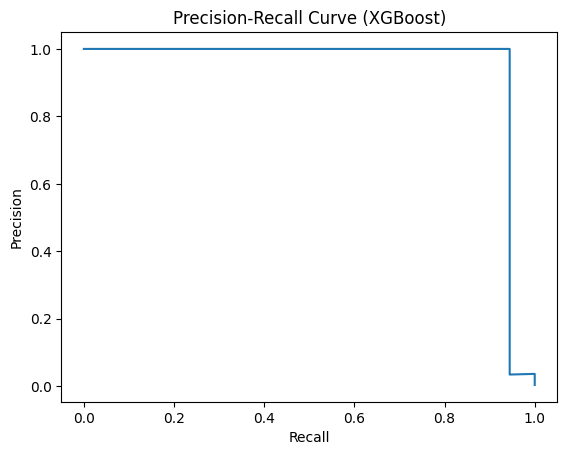

In [21]:
precision, recall, _ = precision_recall_curve(y_test, y_prob)

plt.figure()
plt.plot(recall, precision)
plt.xlabel("Recall")
plt.ylabel("Precision")
plt.title("Precision-Recall Curve (XGBoost)")
plt.show()

ROC-AUC Score: 0.9944491188706586


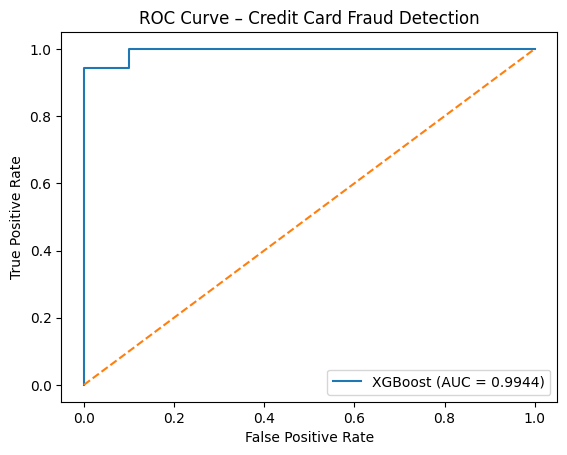

In [22]:
from sklearn.metrics import roc_curve, roc_auc_score
import matplotlib.pyplot as plt
y_prob = best_model.predict_proba(X_test)[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
auc_score = roc_auc_score(y_test, y_prob)
print("ROC-AUC Score:", auc_score)
plt.figure()
plt.plot(fpr, tpr, label=f'XGBoost (AUC = {auc_score:.4f})')
plt.plot([0, 1], [0, 1], linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve – Credit Card Fraud Detection')
plt.legend()
plt.show()
